In [1]:
import datetime
import sys
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import argparse

from argparse import RawTextHelpFormatter
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Model
from sklearn.preprocessing import MinMaxScaler

import src.preprocessing
from src.functions import series_to_supervised, TimeSeriesTensor, create_evaluation_df
from src.functions import plot_train_history, validation, save_model, load_model

np.set_printoptions(threshold=sys.maxsize)

In [6]:
DATA_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) + "/data/"
MODEL_DIR = DATA_DIR+ "/model/"

NameError: name '__file__' is not defined

In [40]:
class Forecaster():
    """
    A class to create a deep time series model
    """
    def __init__(
        self,
        data_path: str,
        model_save: str,
        model_load: str,
        import_file_path: str,
        export_file_path: str,
        granularity: str,
        N_lags: int,
        HORIZON: int,
        PATIENCE: int,
        MAX_EPOCHS: int,
        lag_asfeature: int,
        lag_asfeature2: int,
        NUM_CELLS: int,
        BATCHSIZE: int,
        train_val_split: int,
        n_test: int,
    ):

        self.data_path = data_path
        self.import_file_path = import_file_path
        self.model_save = model_save
        self.model_load = model_load
        self.granularity = granularity
        self.export_file_path = export_file_path
        self.N_lags = N_lags
        self.HORIZON = HORIZON
        self.PATIENCE = PATIENCE
        self.MAX_EPOCHS = MAX_EPOCHS
        self.lag_asfeature = lag_asfeature
        self.lag_asfeature2 = lag_asfeature2
        self.NUM_CELLS = NUM_CELLS
        self.BATCHSIZE = BATCHSIZE
        self.train_val_split = train_val_split
        self.n_test = n_test
    
    def train_test_split(self, df):
        test_df = df.copy()[-self.n_test:]
        train_df = df.copy()[:len(test_df)]
        return train_df, test_df

    def MIMO_fulldata_preparation(self, df):
        df = src.preprocessing.preprocess(df, 'Belgium')
        df = df.merge(series_to_supervised(df), how='right', left_index=True, right_index=True)
        train_df, test_df = self.train_test_split(df)
        y_scaler = MinMaxScaler()
        y_scaler.fit(train_df[['value']])
        long_scaler = MinMaxScaler()
        test_df[test_df.columns] = long_scaler.fit_transform(test_df)
        train_df[train_df.columns] = long_scaler.fit_transform(train_df)
        tensor_structure = {'X':(range(-self.N_lags+1, 1), train_df.columns)}
        train_inputs = TimeSeriesTensor(train_df, 'value', self.HORIZON, tensor_structure)
        test_inputs = TimeSeriesTensor(test_df, 'value', self.HORIZON, tensor_structure)
        return train_inputs, test_inputs, y_scaler
    
    def MIMO_forecastdata_preparation(self, df):
        df = src.preprocessing.preprocess(df, 'Belgium')
        df = df.merge(series_to_supervised(df), how='right', left_index=True, right_index=True)
        y_scaler = MinMaxScaler()
        y_scaler.fit(df[['value']])
        long_scaler = MinMaxScaler()
        df[df.columns] = long_scaler.fit_transform(df)
        tensor_structure = {'X':(range(-self.N_lags+1, 1), df.columns)}
        test_inputs = TimeSeriesTensor(df, 'value', self.HORIZON, tensor_structure)
        return test_inputs, y_scaler
    
    def forecast(self, df):
        test_inputs, y_scaler = self.MIMO_forecastdata_preparation(df)
        predictions = self.model.predict(self.test_inputs['X'])
        eval_df = create_evaluation_df(predictions, self.test_inputs, self.HORIZON, self.y_scaler)
        mape = validation(eval_df['prediction'], eval_df['actual'], 'MAPE')
        rmse = validation(eval_df['prediction'], eval_df['actual'], 'RMSE')
        return eval_df, mape, rmse
    
    def LSTMIMO_train(self):
        train_inputs, test_inputs, y_scaler = self.MIMO_fulldata_preparation(self.data)

        LSTMIMO = tf.keras.models.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(self.NUM_CELLS, input_shape=(self.N_lags, train_inputs['X'].shape[2])),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(self.HORIZON)
        ])
        LSTMIMO.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.PATIENCE, mode='min')

        history = LSTMIMO.fit(train_inputs['X'], train_inputs['target'], batch_size=self.BATCHSIZE, epochs=self.MAX_EPOCHS, validation_split=0.15,
                              callbacks=[early_stopping], verbose=1)
        save_model(LSTMIMO, self.model_save)
        return LSTMIMO, test_inputs, y_scaler
        
    def forecast_test(self):
        #model, test_inputs, y_scaler = LSTMIMO_train()
        predictions = self.model.predict(self.test_inputs['X'])
        eval_df = create_evaluation_df(predictions, self.test_inputs, self.HORIZON, self.y_scaler)
        mape = validation(eval_df['prediction'], eval_df['actual'], 'MAPE')
        rmse = validation(eval_df['prediction'], eval_df['actual'], 'RMSE')
        #print('rmse {}'.format(rmse))
        #print('mae {}'.format(mae))
        return eval_df, mape, rmse
    
    @staticmethod
    def format_output(df):
        df['h'] = df['h'].str.extract('(\d+)', expand=False).astype(int)
        pivot = pd.pivot_table(df, values='prediction', index=['timestamp'], columns=['h'])
        pivot = pivot.add_prefix('Consumer_0_forec_h_')
        return pivot
        
    def configuration(self):
        epilogue_usage = """
        Use cases examples:
        Import the data './building1_input.csv' and use the preloaded model "model_B!_complete" to predict 672 steps ahead and save to './predictions.csv'. The model is loaded from '/../data/model/':
        python forecaster.py -F -i /example_mordor/environment/sauron_eye_consumer_24h.csv -n 196 -e ./predictions.csv -M model_mordor\n

        Train the new model "model_B1_new" on the imported data './Consumption_15min.csv' with n steps for test. The model is saved to '/../data/model/':
        python forecaster.py -T -i /example_mordor/environment/sauron_eye_consumer_24h.csv -M model_mordor -t 1008\n

        """
        parser = argparse.ArgumentParser(description='Make energy consumption forecasts and . Read the example to understand how it works', epilog= epilogue_usage,formatter_class=RawTextHelpFormatter)

        parser.add_argument('-F', '--forecast', action='store_true',  help='Download data from copernicus database', default=False)
        parser.add_argument('-T', '--train',  action='store_true', help='Format data from netcdf file to environment file', default=False)
        parser.add_argument('-i', '--imp_dir', required=True, help='Import a timeseries')
        parser.add_argument('-e', '--exp_dir', help='Export a forecasted timeseries')
        parser.add_argument('-n', '--steps_ahead', help='Number of time steps to forecast')
        parser.add_argument('-t', '--steps_test', help='Number of last time steps in the trainig set'
                                                        'to keep for a test dataset')
        parser.add_argument('-M', '--model', help='Name of model to save/load')


        args = parser.parse_args()
        #print(args)

        # FORECAST
        if args.forecast:
            print('The imported csv is: ',args.imp_dir)
            if args.model:
                print('You decided to use a trained model:',args.model)
                print('\n')
                self.model= load_model(DATA_DIR+'model/'+args.model)
            self.import_file_path = DATA_DIR+args.imp_dir
            self.input_data = pd.read_csv(self.import_file_path, index_col=0)
            self.export_file_path = args.exp_dir
            self.forecast(self.input_data)
            print('\n')
            print('The forecasted timeseries is exported to',args.exp_dir)
            #return test

        # TRAIN
        if args.train:
            print('The imported csv is: ',args.imp_dir)
            print('\n')
            print('You decided to train a new model',args.model)
            print('\n')
            self.model_load = DATA_DIR+'model/'+args.model
            self.data_path = DATA_DIR[:-1]+args.imp_dir
            self.n_test = int(args.steps_test)
            self.data = pd.read_csv(self.data_path, index_col=0)
            self.data = self.data.asfreq(self.data.index.freq or to_offset(self.data.index[1] - self.data.index[0]).freqstr)
            self.granularity = self.data.index.inferred_freq
            print('Data granularity is ',self.granularity)
            print('\n')
            if self.granularity == '15T':
                self.lag_asfeature = 96
                self.lag_asfeature2 = 672
            if self.granularity == 'H':
                self.lag_asfeature = 24
                self.lag_asfeature2 = 168
            self.model, self.test_inputs, self.y_scaler = self.LSTMIMO_train()
            print('\n')
            print('Number of timesteps to use in a test dataset: ',args.steps_test)
            # get error metrics
            output, mape, rmse = forecast_test()
            print('rmse {}'.format(rmse))
            print('mape {}'.format(mape))
            formatted = format_output(output)
            formatted.to_csv(self.export_file_path)


        print('\n')
        print('The end')
        print('\n')    

In [41]:
deep_learner = Forecaster(
    data_path = '../data/Dieteren_case/Consumption_15min.csv',
    import_file_path = '../data/Dieteren_case/Consumption_15min.csv',
    model_save = 'model_Dieteren',
    model_load = 'model_Dieteren',
    granularity = 'H',
    export_file_path = './forecast.csv',
    N_lags = 24,
    HORIZON = 24,
    PATIENCE = 10,
    MAX_EPOCHS = 100,
    lag_asfeature = 24,
    lag_asfeature2 = 168,
    NUM_CELLS = 32,
    BATCHSIZE = 32,
    train_val_split = 0.15,
    n_test = 4380,
    )

In [43]:
deep_learner.data = pd.read_csv(deep_learner.data_path, index_col=0)

In [44]:
deep_learner.model, deep_learner.test_inputs, deep_learner.y_scaler = deep_learner.LSTMIMO_train()

Epoch 1/100
112/112 [==============================] - 2s 22ms/step - loss: 0.0872 - mean_squared_error: 0.0872 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 2/100
112/112 [==============================] - 2s 17ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0403 - val_mean_squared_error: 0.0403
Epoch 3/100
112/112 [==============================] - 2s 18ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 4/100
112/112 [==============================] - 2s 18ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 5/100
112/112 [==============================] - 2s 18ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 6/100
112/112 [==============================] - 2s 16ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 7/100
112/

In [45]:
output, mape, rmse = deep_learner.forecast_test()

In [46]:
output

,timestamp,h,prediction,actual
0,2016-11-17 08:15:00,t+1,598.756672,852.134135
1,2016-11-17 08:30:00,t+1,602.854295,882.950660
2,2016-11-17 08:45:00,t+1,634.596304,849.681891
3,2016-11-17 09:00:00,t+1,579.585319,858.693886
4,2016-11-17 09:15:00,t+1,600.314646,849.293620
...,...,...,...,...
100603,2016-12-30 23:00:00,t+24,261.476656,376.010650
100604,2016-12-30 23:15:00,t+24,255.778979,387.250098
100605,2016-12-30 23:30:00,t+24,241.149930,377.543302
100606,2016-12-30 23:45:00,t+24,228.504873,376.010650


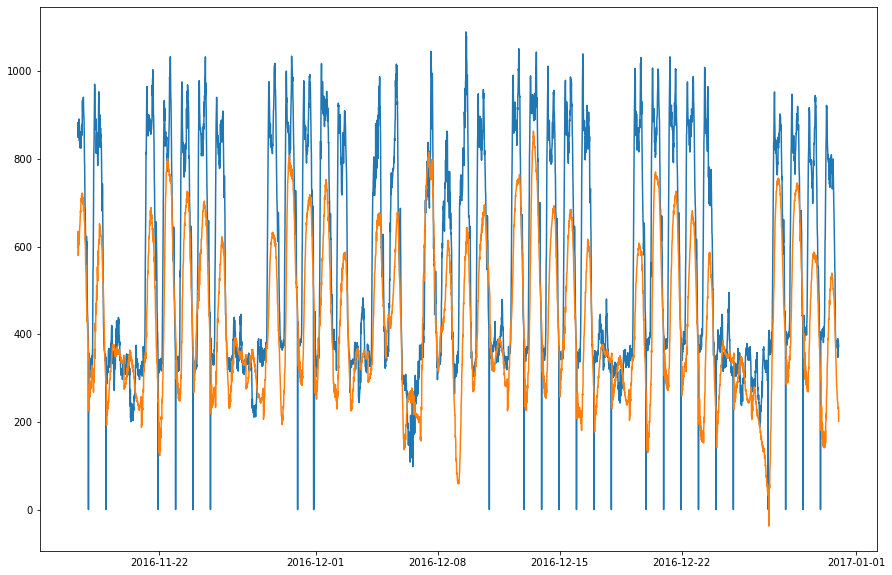

In [47]:
plt.plot(output[output['h']=='t+1']['timestamp'],output[output['h']=='t+1']['actual'])
plt.plot(output[output['h']=='t+1']['timestamp'],output[output['h']=='t+1']['prediction'])
mpl.rcParams['figure.figsize'] = (15, 10)
plt.show()

In [48]:
print('rmse {}'.format(rmse))
print('mape {}'.format(mape))
formatted = deep_learner.format_output(output)

rmse 286.7718908690878
mape 35.503862502052


In [51]:
deep_learner.input_data = pd.read_csv(deep_learner.import_file_path, index_col=0)
deep_learner.export_file_path = deep_learner.export_file_path,
output, mape, rmse = deep_learner.forecast(deep_learner.input_data)

In [52]:
print('rmse {}'.format(rmse))
print('mape {}'.format(mape))
formatted = deep_learner.format_output(output)

rmse 286.7718908690878
mape 35.503862502052


In [ ]:
if __name__ == "__main__":
    deep_learner = Forecaster(
    # Here I initialize some settings, these are default ones if no user input
    # USER INPUT SETTINGS
    model_load = DATA_DIR+"model_B1_complete",
    granularity = '15T',
    import_file_path = './building1_input.csv',
    export_file_path = './predictions.csv',
    # ADVANCED TRAINING SETTINGS
    data_path = DATA_DIR+'Consumption_1H.csv',
    model_save = DATA_DIR+"model_B1_complete",
    lag = 24,
    lag2 = 168,
    LSTM_layer_depth = 50,
    epochs = 100,
    batch_size = 128,
    train_test_split = 0.15,
    n_test = 672*4
    )
    deep_learner.configuration()

In [41]:
data_path = '../data/Dieteren_case/Consumption_15min.csv'
import_file_path = '../data/Dieteren_case/Consumption_15min.csv'
model_save = 'model_Dieteren'
model_load = 'model_Dieteren'
granularity = 'H'
export_file_path = './forecast.csv'
N_lags = 24
HORIZON = 24
PATIENCE = 10
MAX_EPOCHS = 100
lag_asfeature = 24
lag_asfeature2 = 168
NUM_CELLS = 32
BATCHSIZE = 32
train_val_split = 0.15
n_test = 4380